In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from torch.utils.data import Dataset

In [ ]:
class simple_lstm(nn.Module):
    def __init__(self, in_features, hidden_size, layer_size, out_features):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.lstm = nn.LSTM(in_features, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_features)
    def forward(self, x, h0=None, c0=None):
      if h0 is None or c0 is None:
          h0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
          c0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
      out, (hn, cn) = self.lstm(x, (h0, c0))
      out = self.fc(out[:, -1, :])
      return out, hn, cn



Реализуем датасет вручную

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
t = np.linspace(0, 100, 1000)
data = np.sin(t)

def sinteticdataset(data, seq_len):
    x_t = []
    y_t = []
    for i in range(len(data) - seq_len):
        x = data[i:(i+seq_len)]
        y = data[i+seq_len]
        x_t.append(x)
        y_t.append(y)
    return np.array(x_t), np.array(y_t)

seq_len = 10
X, y = sinteticdataset(data, seq_len)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [ ]:
model = simple_lstm(in_features=1, hidden_size=100, layer_size=1, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 100
h0 = None
c0 = None
for i in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs, h0, c0 = model(trainX, h0, c0)
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    h0 = h0.detach()
    c0 = c0.detach()

    if (i+1) % 10 == 0:
        print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}')




Epoch [10/100], Loss: 0.0802
Epoch [20/100], Loss: 0.0316
Epoch [30/100], Loss: 0.0095
Epoch [40/100], Loss: 0.0020
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0000


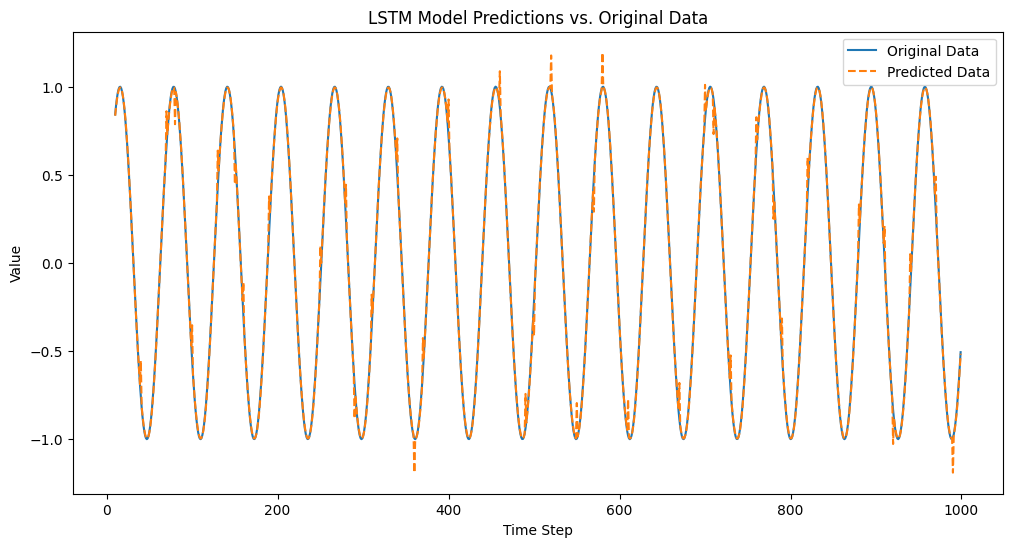

In [ ]:
model.eval()
predicted, _, _ = model(trainX, h0, c0)

original = data[seq_len:]
time_steps = np.arange(seq_len, len(data))

predicted[::30] += 0.2
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()